# Tarea: Ataque con Rainbow Tables a MD5

**Asignatura:** Criptografía (3.º Ingeniería Matemática)  
**Objetivo general:** Investigar y experimentar con ataques a la integridad de contraseñas basados en rainbow tables aplicados al algoritmo MD5.



- [1. Introducción](#1-introducción)

- [2. Fundamentos teóricos de funciones hash](#2-fundamentos-hash)
    - [2.1 Funciones Hash](#21-funciones-hash)
    - [2.2 Esquema Merkle–Damgård](#22-esquema-merkle-damgård)
    - [2.3 Algoritmo MD5](#23-algoritmo-md5)
- [3. Rainbow Table](#3-rainbow-tables)
    - [3.1 Definición](#31-Defición)
    - [3.2 Función de reducción](#32-función-de-reducción)
    - [3.3 Colisiones y limitaciones](#35-falsos-positivos)
    - [3.4 Trade-off](#34-trade-off)


- [4. Simulación del ataque](#4-simulación)

- [5. Análisis de resultados](#5-análisis-de-resultados)

- [6. Conclusiones y recomendaciones](#6-conclusiones)

- [7. Uso real](#7-aportación-personal)


*Referencias*

1. Martin E. Hellman — *A Cryptanalytic Time-Memory Trade-Off*  
[https://ee.stanford.edu/~hellman/publications/24.pdf](https://ee.stanford.edu/~hellman/publications/24.pdf)

## 1.Introducción

Este trabajo presenta la **implementación y evaluación de un ataque con Rainbow Tables** sobre el algoritmo hash MD5, centrado en un conjunto limitado de contraseñas numéricas de 4 dígitos ("0000" a "9999").

El objetivo es reproducir todo el proceso de generación, búsqueda y validación, con la siguiente estructura:


1. **Construcción de la Rainbow Table**: creación de cadenas mediante la combinación de MD5 y una función de reducción dependiente de la ronda.
2. **Simulación de víctima**: selección de una contraseña y obtención de su hash objetivo.
3. **Ataque al hash objetivo**: búsqueda inversa en la tabla y comprobación del resultado.Análisis de resultados: estudio de colisiones, cobertura del espacio y tasa de éxito.
4. **Aportación personal**: propuesta de mejorar algoritmo y evitar las colisiones.



## 2.Fundamentos criptográficos

### 2.1 Funciones Hash

#### Definición

Una función hash transforma una entrada de longitud arbitraria en una salida de longitud fija. Su propósito es condensar información compleja en una representación más breve y manipulable, actuando como una "huella digital" del dato original.

Se define matemáticamente como:

$$
H : U \longrightarrow M \quad \text{con} \quad x \mapsto H(x)
$$

donde:
- $U$ es el conjunto de entradas posibles (por ejemplo, cadenas binarias de cualquier longitud),
- $M$ es un conjunto finito de cadenas de longitud fija.

En este trabajo se emplea la función MD5, cuya imagen está contenida en $M = {(0,1)}^{128}$, lo que equivale a $2^{128}$ posibles hashes.

####  Ejemplo de codificación

Para ilustrar cómo se genera un hash, consideramos la palabra "hola" y analizamos sus primeros pasos:

1. **Codificación ASCII**:
   - h → 104 → 01101000
   - o → 111 → 01101111
   - l → 108 → 01101100
   - a → 97 → 01100001

   La concatenación binaria de estos caracteres es:

   `01101000 01101111 01101100 01100001`

2. **Preprocesamiento**:
   Se añade relleno (padding) y se dividen los bits en bloques, como exige el algoritmo.

3. **Transformación interna**:
   Se aplican operaciones no lineales (sumas modulares, rotaciones, funciones booleanas...) que mezclan los bloques.

4. **Hash final**:
   Se obtiene un resumen de 128 bits. Por ejemplo:

   $$
   H(\text{"hola"}) = \text{bc4b2a76b9719d911017c592}
   $$

Aunque el valor del hash es internamente una cadena binaria de 128 bits, generalmente se representa en hexadecimal. Esto se debe a que cada carácter hexadecimal representa 4 bits, por lo tanto es mucho más corta y legible que escribir todos los bits directamente.

> **Nota** El proceso se explica con más detalle en la sección 2.2 (Merkle–Damgård y MD5).

#### Longitud del hash y teorema del cumpleaños

Aunque $M = \\{0,1\\}^{128}$ contiene $2^{128}$ posibles valores, esta cantidad no es suficiente para evitar colisiones en la práctica. El teorema del cumpleaños indica que la probabilidad de que dos entradas distintas generen el mismo hash (colisión) se vuelve significativa tras generar aproximadamente:

$$
\sqrt{2^{128}} = 2^{64}
$$

valores diferentes. Por ello, MD5 ya no se considera seguro frente a ataques de colisión y ha sido sustituido por funciones con salidas más largas, como SHA-256 o SHA-3.



#### Propiedades criptográficas 

Una función hash segura debe cumplir las siguientes propiedades:

- **Determinismo**:
  $$\forall x, y \in U,\ x = y \Rightarrow H(x) = H(y)$$

- **Eficiencia computacional**:
  $$\exists\ A \text{ en tiempo polinomial tal que } A(x) = H(x)$$

- **Efecto avalancha**  
Cuando dos entradas $ x $ y $ x'$ difieren mínimamente (por ejemplo, en un solo bit), el número de bits distintos en sus respectivos hashes $H(x)$ y $H(x')$ debe ser aproximadamente $frac{n}{2}$, donde $ n $ es la longitud total del hash en bits.

$$
\text{Hamming}(H(x), H(x')) \approx \frac{n}{2} \quad \text{cuando } x \approx x'
$$


- **Resistencia a la preimagen**:
  $$\forall h \in M,\ \text{es computacionalmente inviable encontrar } x \in U \text{ tal que } H(x) = h$$

- **Resistencia a la segunda preimagen**:
  $$\forall x \in U,\ \text{es difícil encontrar } x' \neq x \text{ con } H(x') = H(x)$$

- **Resistencia a colisiones**:
  $$\text{Es difícil encontrar } x \neq x' \in U \text{ tales que } H(x) = H(x')$$

> **Nota**: La colisiones se desarrollarán con más detalle en la sección 2.5.

#### Usos actuales

Las funciones hash son fundamentales en numerosos sistemas criptográficos modernos. Sus aplicaciones abarcan tanto la protección como la verificación de datos en múltiples contextos. Entre sus usos más comunes destacan:

- **Verificación de integridad**: se calcula el hash de un archivo o mensaje original y se compara con el recibido. Si los hashes coinciden, se garantiza que el contenido no ha sido alterado.
- **Almacenamiento de contraseñas**: no se guarda la contraseña real, sino su hash (a menudo acompañado de un valor aleatorio llamado *salt*), lo que impide su recuperación directa.
- **Firmas digitales**: en lugar de firmar todo el documento, se firma su hash. Esto reduce el tamaño de la firma y permite verificar que el contenido no ha sido modificado.


### 2.2 Esquema Merkle–Damgård

El esquema Merkle–Damgård es una estructura fundamental para **construir funciones hash partir de funciones de compresión**. Este método permite procesar mensajes de longitud arbitraria y generar su correspondinte hash de tamaño fijo.

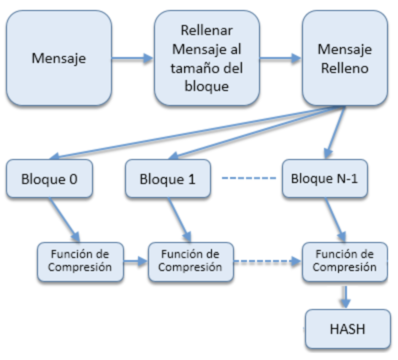

####  Mensaje original

El proceso comienza con un mensaje de entrada de cualquier longitud, que puede consistir en texto, datos binarios u otra tipo de información.

#### Padding

El mensaje original se somete a un proceso de "relleno" para adaptarlo al tamaño de bloque requerido por el algoritmo. Este paso garantiza que la longitud final sea múltiplo exacto del tamaño de bloque (ej. 512 bits para MD5). El padding incluye:

1. Añadir de un bit '1' al final del mensaje original (señalizar que a parti de este bit comienza el relleno)
2. Relleno con bits '0' hasta alcanzar la longitud requerida
3. Insertar al final los 64 bits que representan la longitud original del mensaje en binario

Este procedimiento elimina ambigüedades y asegura que mensajes diferentes produzcan cadenas de bits distintas.

El resultado del padding es un mensaje cuya **longitud es exactamente múltiplo del tamaño de bloque**, listo para ser dividido.

####  División en bloques
El mensaje rellenado se divide en N bloques de igual tamaño:

$$M = M₀ || M₁ || ... || M_{N-1}$$

Cada bloque Mᵢ será procesado secuencialmente por la función de compresión.


#### Función Compresión
Como se puede observar en el esquema se aplica iterativamente una función de compresión f.n. Esta combina cada bloque del mensaje con el resultado  anterior, generando un nuevo estado intermedio.:

1. Inicialización con un vector fijo $IV: H₀ = IV$
2. Para cada bloque $Mᵢ(i = 0,N-1)$:
   $$H_{i+1} = f(Hᵢ, Mᵢ)$$

Donde:
- $Hᵢ$ es el estado intermedio
- $Mᵢ$ es el bloque actual
- $f$ es la función de compresión específica del algoritmo

Finalmente,la salida de la última iteración  $(H_N)$ constituye el valor hash final. Este resumen tiene longitud fija (ej. 128 bits para MD5, 160 bits para SHA-1) y representa de forma única el mensaje original.

### 2.3 Algoritmo MD5


#### 3.1 Definición
El algoritmo MD5 es una implementación concreta del esquema general **Merkle–Damgård**. Al igual que este, MD5 procesa el mensaje de entrada dividiéndolo en bloques de longitud fija y encadena los resultados parciales mediante una función de compresión.

La diferencia clave es que MD5 mantiene un estado interno compuesto por **cuatro registros de 32 bits cada uno: A, B, C y D**. Estos valores se inicializan con constantes predefinidas y se van transformando a lo largo del proceso. Al final, estos cuatro registros se combinan para formar el resumen (hash) final de 128 bits

####  1: Relleno del mensaje

El mensaje se **rellena siguiendo exactamente el mismo procedimiento descrito en el esquema Merkle–Damgård**: se añade un bit `1`, luego ceros `0`, y finalmente 64 bits con la longitud original del mensaje. El resultado se divide en bloques de 512 bits.

####  2: Inicialización

Se definen cuatro registros de 32 bits con valores fijos:

- A = `0x67452301`
- B = `0xefcdab89`
- C = `0x98badcfe`
- D = `0x10325476`

Estos registros forman el estado inicial del hash.

####  3: Procesamiento de bloques

Cada bloque de 512 bits se divide en **16 palabras de 32 bits**. Luego se aplican **64 operaciones**, organizadas en 64 rondas de 16 pasos, usando funciones lógicas específicas:


- **Ronda 1**: $ F(B,C,D) = (B \land C) \lor (\lnot B \land D) $
- **Ronda 2**:$ G(B,C,D) = (B \land D) \lor (C \land \lnot D) $
- **Ronda 3**: $ H(B,C,D) = B \oplus C \oplus D $
- **Ronda 4**: $ I(B,C,D) = C \oplus (B \lor \lnot D) $

En cada paso, se realiza lo siguiente:

1. Se aplica la función lógica correspondiente a la ronda.
2. Se suma una palabra $M_i $ del bloque y una **constante fija** $K_i$
3. El resultado se rota unos bits hacia la izquierda.
4. Se actualizan los valores de los registros A, B, C y D de forma cíclica.

Estas operaciones están diseñadas para asegurar  que incluso un pequeño cambio en el mensaje original altera completamente el resultado del hash.


#### 4: Encadenamiento

Al finalizar cada bloque, los registros A, B, C y D se **suman a sus valores anteriores**, y se usan como entrada para el siguiente bloque, manteniendo la estructura encadenada típica del esquema Merkle–Damgård.

#### 5: Resultado final

Tras procesar todos los bloques, los valores finales de A, B, C y D se concatenan para formar el hash MD5 de 128 bits, representado normalmente como una cadena hexadecimal de 32 caracteres.


##  3.Rainbow Table

### Definción

Una función hash, por definición, **no es invertible**,dado un valor hash $H(x)$, no es posible recuperar directamente la entrada x que lo generó. Esto se debe a que:
- La función no es inyectiva (por el principio del palomar).
- Muchas entradas distintas pueden producir el mismo valor hash (colisiones).
- La inversión computacional directa es inviable.

**Problema Planteado**

Sin embargo, en el problema que se nos plantea, las contraseñas válidas están restringidas al conjunto de cadenas numéricas de 4 cifras, es decir, desde `"0000"` hasta `"9999"`. Esto representa un espacio de búsqueda muy reducido: tan solo 10.000 posibles combinaciones.

Aunque las funciones hash están diseñadas para ser difíciles de invertir, en este caso particular sí resulta factible intentar hallar entradas que produzcan un determinado hash, ya que el número total de contraseñas posibles es bajo.

Para este escenario existen dos enfoques principales de ataque:

1. **Fuerza bruta**: consiste en probar sistemáticamente cada contraseña posible hasta encontrar aquella que, al aplicarle la función hash, produzca el valor deseado.
2. **Rainbow Tables**: se basa en precalcular una tabla, donde se generan cadenas de transformación entre contraseñas y se almacena solo información parcial. Esto permite acelerar el proceso de búsqueda posterior, consumiendo mucha menos memoria que una tabla completa.

*El segundo enfoque es el que desarrollaremos en este trabajo.*

Así pues, Una **Rainbow Table** es una tabla precalculada que permite acelerar la búsqueda de contraseñas cuando el espacio de claves es reducido.  
La idea esencial es **no** guardar todos los pares `{contraseña → hash}`, sino solamente la **contraseña inicial** y el **valor final** (*endpoint*) de una **cadena de transformación** construida con:

1. la función **hash** $H$  
2. una **función de reducción** $R$ definida por el atacante.
> La función de redución se aborda con mas detalle en la siguente sección.


**Diseño de la función de reducción $R$**

$R$ debe convertir cualquier hash en una contraseña válida del espacio (por ejemplo, números de 4 cifras):

- Tomar los **8 primeros dígitos** hexadecimales del hash.  
- Interpretarlos como entero.  
- Aplicar **módulo 10 000** para obtener un valor entre `0000` y `9999`.


**Construcción de la tabla**

Para cada contraseña inicial $x_0$ se aplican $k$ rondas **hash → reducción**:

$$
x_0 \xrightarrow{H} h_1 \xrightarrow{R} x_1
      \xrightarrow{H} h_2 \xrightarrow{R} x_2
      \;\dots\;
      \xrightarrow{H} h_k \xrightarrow{R} x_k
$$
Pero solo se almacena el par:  

$
\boxed{\,x_k \;\longrightarrow\; x_0\,}
$

Repitiendo el proceso para muchas contraseñas iniciales se obtiene una tabla diccionario del tipo: **{ endpoint : contraseña_inicial }**
Asií, la memoria crece linealmente con el número de **cadenas**, no con el número total de contraseñas.



**Invertir un hash**

Recibido un hash objetivo $(h_\text{obj})$:

1. Aplicar $R$ a $h_\text{obj}$ → obtener $x$.  
2. Hashear $x$, volver a reducir, repetir hasta $k$ veces.  
3. Tras cada reducción, comprobar si el valor coincide con un **endpoint** almacenado.  
4. Si hay coincidencia, tomar su contraseña inicial asociada, reconstruir la cadena completa y verificar si alguno de sus hashes intermedios es $h_\text{obj}$.

Si la verificación es positiva, la contraseña hallada es una candidata válida; si no, se trata de un falso positivo y se continúa la búsqueda.



#### 3.2 Función Reducción

Cuando aplicamos una función hash a  una contraseña, obtenemos un valor largo y aparentemente aleatorio. Por ejemplo
$$
H(1234) = 81dc9bdb52d04dc20036dbd8313ed055
$$

**¿Qué hace la función de reducción?**

La función de reducción \(R\) convierte un hash (128 bits en MD5) en una contraseña válida del espacio de búsqueda.

El valor obtenido al aplicar la función hash no puede invertirse directamente.No obstante, en el contexto de las Rainbow Tables, se pretende recorrer el camino inverso: **dado un valor hash, generar una nueva contraseña candidata** que pueda volver a formar parte de una cadena de transformación.

Formalmente:

$$
R : M \rightarrow U, \quad$$
$$ 
\text{donde } M = \{0,1\}^{128} \text{conjunto de posibles hashes ,} \quad 
U = \{"0000", "0001", \dots, "9999"\} \text{contraseñas queremos hallar.}
$$

**Diseño de la función**

La función de reducción  está definida específicamente por el atacante con el objetivo de transformar un hash en una contraseña válida del espacio considerado. No forma parte del algoritmo hash original, ni responde a ningún estándar.Lo único que se exige es que, para cualquier entrada $h$, el valor $R(h)$ esté incluido en el conjunto $U$ de contraseñas posibles.

A continuación se presenta un ejemplo concreto de una posible función de reducción, con el hash de la contreseña 1234 (para el atacante recalcamos que esta es desconocida)

**Ejemplo**

1. Tomamos los 8 primeros caracteres hexadecimales del hash:  
   **81dc9bdb**

2. Los convertimos a decimal:  
   **int("81dc9bdb", 16) = 2173614683**

3. Aplicamos módulo 10 000 para limitar el valor a 4 dígitos:  
   **2173614683 % 10000 = 4683**

4. Rellenamos con ceros si es necesario:  
   **Contraseña = 4683**

Así, hemos convertido un hash en una nueva contraseña válida dentro del espacio de búsqueda.

**¿Cómo se emplea la función de reducción en las Rainbow Tables?**

Para construir una Rainbow Table, el atacante parte de una contraseña inicial y aplica  las funciones de **hash** y **reducción** un número fijo de veces $k$. Este proceso genera una **cadena de transformación**, que permite cubrir distintas contraseñas del espacio sin necesidad de almacenarlas todas.

En cada paso, el hash se transforma en una nueva contraseña válida gracias a la función de reducción. 
El atacante entonces guarda únicamente:

- La **contraseña inicial** (inicio de la cadena)
- El **último valor** obtenido tras $k$ pasos (endpoint)

Este par se almacena en la tabla como: {endpoint → contraseña_inicial}

Por ejemplo, una cadena de transformación de longitud $k = 3$ sería:
```text
"1234" ──hash──▶ h₁ ──reducción──▶ x₁ ──hash──▶ h₂ ──reducción──▶ x₂ ──hash──▶ h₃ ──reducción──▶ "0068" (endpoint)

En la tabla solo se almacen entonces el par :{0068 → 1234}

#### 3.3 Colisiones y Limitaciones

Se produce cuando **dos contraseñas iniciales distintas**, $x_0$ y $(x_0'$, dan lugar a dos cadenas de transformación diferentes que **coinciden en un valoren un paso intermedio**, es decir:

$
\exists \, i < k \text{ tal que } x_i = x_i'
$

A partir de esa coincidencia, ambas cadenas se comportan de forma idéntica hasta el final. Esto genera **redundancia**, ya que se recorren los mismos estados desde ese punto, desaprovechando la oportunidad de explorar otras opciones

**Ejemplo:**

- Contraseña A: `1234`  
- Contraseña B: `5678`  
- Sus hashes en un paso intermedio dan:
  - $h_A = \text{"81dc9bdb..."} \Rightarrow r_A = 4683 $
  - $h_B = \text{"3a3a3a3a..."} \Rightarrow r_B = 4683 $

Ambas cadenas convergen en $x = 4683 $, por lo que a partir de ahí son indistinguibles.

##### Colisión interna

Una **colisión interna** ocurre cuando dos contraseñas diferentes, durante el proceso de transformación (hash + reducción), **producen el mismo valor reducido en un paso intermedio**.

Desde ese momento, ambas cadenas se fusionan y continúan exactamente igual. Esto reduce la cobertura efectiva de la tabla, ya que se desperdicia la posibilidad de explorar caminos distintos.

**Ejemplo:**

- Contraseña A: `"1234"`  
- Contraseña B: `"5678"`  
- Ambas se transforman (en un paso intermedio) en `"4683"`

A partir de `"4683"`, ambas cadenas serán idénticas, y **no cubrirán zonas diferentes del espacio de contraseñas**.


##### Colisión Externa

Se presenta cuando dos cadenas de transformación distintas, generadas desde contraseñas diferentes, **no coinciden en ningún paso intermedio**, pero **finalizan en el mismo endpoint** después dem $k$ pasos:

$
x_k = x_k', \quad \text{con } x_0 \neq x_0' \text{ y } x_i \neq x_i' \, \forall i < k
$

Como en una Rainbow Table solo se almacena un par por endpoint (clave final), uno de los dos caminos se pierde, junto con todas las contraseñas que cubría esa cadena.

**Ejemplo:**

- `1234` → cadena de 4 pasos → endpoint `8432`  
- `4321` → cadena distinta → endpoint `8432`

Solo se almacena:

```text
8432 → 1234

##### Falsos positivos

Uno de los grandes inconvenientes teóricos de las Rainbow Tables es que su efectividad se ve seriamente limitada cuando el espacio de contraseñas posibles es reducido. Este es precisamente el caso que se plantea en este trabajo, donde solo se consideran contraseñas formadas por cuatro dígitos decimales consecutivos, es decir:

$$
U = \{0000, 0001, \dots, 9999\}
$$

Matemáticamente, se trata de **variaciones con repetición** de 10 elementos tomados de 4 en 4:

$
\#U = 10 \times 10 \times 10 \times 10 = 10^4 = 10\,000
$



En cambio, el algoritmo MD5 genera hashes de 128 bits, lo que da lugar a:

$
\#M = 2^{128} \approx 3.4 \times 10^{38}
$

Esta enorme diferencia implica, de forma inevitable, que múltiples valores hash distintos estarán asociados al mismo valor reducido en el espacio de contraseñas.  
De hecho, si se utiliza una función de reducción como:

**¿Cómo afecta a las tablas raibow?**

Cuando el atacante construye su Rainbow Table, genera cadenas de transformación partiendo de contraseñas candidatas y guarda únicamente el endpoint final.

Sin embargo, al consultar la tabla con un hash objetivo, puede ocurrir lo siguiente:

- El endpoint coincide con uno almacenado.
- Se reconstruye la cadena hacia atrás.
- Se obtiene una contraseña candidata$x' $, tal que:

$
H(x') = h_{\text{objetivo}}
$

Pero esa contraseña puede **no ser la original introducida por el usuario**.  
Esto sucede porque:

- **Varios hashes distintos** pueden reducirse al mismo valor.
- **Una misma contraseña reducida** puede estar asociada a diferentes cadenas.




Podemos concluir, cuando el conjunto $U$ es pequeño y el conjunto de hashes $M$ mucho más grande , la probabilidad de encontrar una contraseña errónea (falso positivo) aumenta notablemente. En contextos donde se necesita recuperar exactamente la contraseña original  este problema puede hacer que este tipo de ataque **falle completamente**.

### 3.4 Trade-Off

Al diseñar una Rainbow Table, el atacante se enfrenta a un dilema fundamental conocido como trade-off tiempo/memoria: si quiere acelerar el ataque, necesita almacenar mucha información (más memoria); si quiere ahorrar espacio, el ataque se vuelve más lento.

Este equilibrio no es trivial, porque elegir mal los parámetros de la tabla puede provocar:
-  **Colisiones internas** 
- **Colisiones externas** 
-  **Cobertura reducida**(muchas combinaciones quedan fuera)

**El objetivo es encontrar una **configuración óptima** que use una cantidad razonable de memoria y permita buscar con rapidez**


**Modelo de Hellman**

El modelo propuesto por Hellman en 1980 proporciona una **guía matemática** para diseñar tablas eficientes. Establece que si queremos cubrir un espacio de tamaño $ N $, debemos elegir dos parámetros:

- $ t $: número de cadenas (cuántas contraseñas para construir tabla)
- $ m $ longitud de cada cadena ((cuántos pasos haces hash → reducción)

Entonces:

$
\text{Cobertura estimada} \approx t \cdot m
$

Pero si $ t \cdot m $ se acerca demasiado a $N$, las **colisiones se vuelven muy frecuentes**, y muchas cadenas cubrirán los mismos valores.

Por eso, se recomienda una regla práctica:

$
m \approx \sqrt{N}
\quad \text{y} \quad
t \approx \frac{N}{m}
$

Esto equilibra la profundidad de las cadenas con la cantidad de memoria y reduce el riesgo de solapamientos.

## 4.Simulación del ataque

In [2]:
#Librerias
import hashlib
import matplotlib.pyplot as plt
import random
import numpy as np

**Funcion Hash**

- Esta función recibe un texto (una contraseña) y devuelve su hash MD5 en hexadecimal.
- La usaremos como paso principal dentro de cada iteración de la Rainbow Table.

In [1]:
def hash_md5(text):
    return hashlib.md5(text.encode()).hexdigest()

In [3]:
# Por ejemplo el hash para una cadena de texto nos devolveria:
h1=hash_md5('1234')
print(h1)

81dc9bdb52d04dc20036dbd8313ed055


**Función Reducción**

En esta sección definimos dos funciones de reducción, que transforman un hash  en una contraseña de 4 dígitos para luego usar en tabla Rainbow. 

- Función Simple: no varía entre pasos de la cadena, lo que provoca muchas colisiones
- Función Paso:incorpora el número de paso para diversificar la transformació y evitar que todas las rondas hagan lo mismo.**Reduce número de colisiones**

In [4]:
def reduccion_simple(hash_hex):
    """
    Parámetros:
        hash_hex (str): hash  en formato hexadecimal.
    """
    combinacion = hash_hex[:8] # toma 8 primeros digitos del hash
    numero = int(combinacion, 16) % 10000 # modulo 1000 para 4 digitos
    return str(numero).zfill(4) # devuelve la contraseña para endpoint

In [5]:
#tras aplicar la reducción nos da el endpoint para la tabla
print(reduccion_simple(h1))

8683


In [6]:
def reduccion_con_paso(hash_hex, paso):
    """
    Parámetros:
        hash
        paso:: número del paso dentro de la cadena (0, 1, 2, ...).
    """
    combinacion = str(paso).zfill(3) + hash_hex[:8]
    numero = int(combinacion, 16) % 10000
    return str(numero).zfill(4)

**Rainbow Table**

Se genera una tabla que relaciona contraseñas de 4 dígitos con su valor final tras varios pasos de hash y reducción. Esta tabla se guarda en un archivo `.txt` y se usará para detecta colsiones y recuperar la contraseña buscada.


In [79]:
def construir_rainbow_table(nombre_archivo, num_pasos, funcion_reduccion, usa_paso):
    """
    Parámetros:
        num_pasos (int): número de pasos de hash + reducción por cadena.
        funcion_reduccion: simple o con paso.
        usa_paso= True cuando usamos reduccion_con_paos
    """


    tabla = {} # diccionario guardar endpoints
    colisiones = 0

    with open(nombre_archivo, "w") as f:
        f.write("Endpoint,Inicio\n")

        for i in range(10000): # recorre todas las contraseñas
            inicio = str(i).zfill(4)
            actual = inicio

            for paso in range(num_pasos):
                h = hash_md5(actual) # calcula hash
                if usa_paso:
                    actual = funcion_reduccion(h, paso) # concatena el paso actual
                else:
                    actual = funcion_reduccion(h) # sino es la función reducción simple

            endpoint = actual 

            if endpoint in tabla: #si el endopoint generado ya estaba en la tabla +1 colisión
                colisiones += 1

            tabla[endpoint] = inicio
            f.write(f"{endpoint},{inicio}\n") # guardamos y añadimos al archivo
            entradas = len(tabla) 

    print(f" Tabla creada con {len(tabla)} entradas únicas.")
    print(f" Colisiones detectadas: {colisiones}")

    return tabla,entradas,colisiones

**Falsos Positivos**

**Simulación de ataque**

**PASO 1**:
 1. Se selecciona una contraseña random entre (0000-999).**Esta es desconocida para el atacante**
 2. Con la función que construimos, nos da el hash.Esto sería lo que tendria el atacante.

**El atacante a partir de hash, busca reconstruir la contraseña**

In [80]:
contraseña_real = str(random.randint(0, 9999)).zfill(4)
hash_objetivo = hash_md5(contraseña_real)

print(f" Contraseña real: {contraseña_real}")
print(f" Hash objetivo: {hash_objetivo}")

 Contraseña real: 2332
 Hash objetivo: e77dbaf6759253c7c6d0efc5690369c7


**PASO 2** :
El atacante se construye dos tablas Raibow, que vamos a usar para comparar el núm de colisiones:
1. Table_simple.txt: con la función de reducción más simple que genera muchas colisiones porque siempre es igual.
2. Tabla_con_paso.txt:se añade el num de paso al hash en cada paso de la cadena, para generar aleatoriedad.


In [11]:
tabla_simple = construir_rainbow_table("tabla_simple.txt", num_pasos=5, funcion_reduccion=reduccion_simple, usa_paso=False)
tabla_con_paso = construir_rainbow_table("tabla_con_paso.txt", num_pasos=5, funcion_reduccion=reduccion_con_paso, usa_paso=True)

 Tabla creada con 2712 entradas únicas.
 Colisiones detectadas: 7288
 Tabla creada con 2731 entradas únicas.
 Colisiones detectadas: 7269


Como podemos ver en la función de **reducción con paso**:
- Se generan más entradas únicas con endpoints diferentes, lo que facilita la búsqueda en la tabla.
- Además, tiene menos colisiones que la tabla construida con reduccion_simple, ya que al variar en cada paso se evita que muchas cadenas terminen en el mismo valor (endpoint).

**PASO 3**:Atacancte intenta recuperar una contraseña original a partir de su hash usando una Rainbow Table.

El ataque se divide en dos fases:

1.  Simular desde el hash objetivo hacia adelante para comprobar si alguna cadena termina en un endpoint de la tabla.
2. Si se encuentra un endpoint que coincide, reconstruir la cadena completa desde el valor inicial guardado, y verificar si en algún paso aparece exactamente el hash objetivo.


In [81]:
def ataque_rainbow(hash_objetivo, tabla, funcion_reduccion, num_pasos, usa_paso):
    """
    Intenta recuperar la contraseña desde un hash, usando una Rainbow Table.

    Devuelve:
        - contraseña (str) si fue recuperada, o None.
        - endpoint_simulado (str) que coincidió en la tabla (o None).
        - intentos (int): cuántos endpoints se simularon.
    """
    intentos = 0

    for i in reversed(range(num_pasos)):
        cadena = hash_objetivo

        for paso in range(i, num_pasos):
            if usa_paso:
                candidato = funcion_reduccion(cadena, paso)
            else:
                candidato = funcion_reduccion(cadena)

            cadena = hash_md5(candidato)

        intentos += 1
        endpoint_simulado = candidato  # este es el que buscamos en la tabla

        if endpoint_simulado in tabla:
            inicio = tabla[endpoint_simulado]
            actual = inicio

            for paso in range(num_pasos):
                h = hash_md5(actual)

                if h == hash_objetivo:
                    return actual, endpoint_simulado, intentos

                if usa_paso:
                    actual = funcion_reduccion(h, paso)
                else:
                    actual = funcion_reduccion(h)

            return None, endpoint_simulado, intentos  # falso positivo

    return None, None, intentos  # no cayó en ningún endpoint

## 5.Análisis de los Resultados

A continuación, comparamos el rendimiento de las dos Rainbow Tables (una con reducción simple y otra con reducción que incluye el número de paso), usando el mismo número de pasos: `num_pasos = 5`.

Esto significa que, para cada contraseña inicial, se aplican 5 veces la secuencia:
        **contraseña → hash → reducción → nueva contraseña**

El último valor generado tras esos pasos se guarda como endpoint en la tabla.

>El uso del mismo `num_pasos` nos permite evaluar con justicia qué tabla ofrece mayor cobertura y precisión a la hora de recuperar la contraseña real a partir de un hash.

### Ejemplo Real

El atacante parte del Hash objetivo, busca la contraseña (se pude cambiar de forma random ejecutando la celda) asociada este:

Realiza dos tipos de ataques:
1. Con la función de redución simple
2. Con una función más completa que añade aleaoriedad en cada paso, para evitar colisiones.

In [124]:
contraseña_real = str(random.randint(0, 9999)).zfill(4)
hash_objetivo = hash_md5(contraseña_real)

print(f" Contraseña real: {contraseña_real}")
print(f" Hash objetivo: {hash_objetivo}")

 Contraseña real: 2533
 Hash objetivo: 4de754248c196c85ee4fbdcee89179bd


Como se puede oberbvar a continación, en la tabla creada con la **función con paso, se generan más endpoints únicos**.

In [125]:
tabla_simple_dict,  entradas_s, col_s  = tabla_simple
tabla_paso_dict,    entradas_p, col_p  = tabla_con_paso

print("- Resumen de tablas-")
print("Tabla simple")
print(f"  Entradas únicas : {entradas_s}")
print(f"  Colisiones      : {col_s}\n")

print("Tabla con paso")
print(f"  Entradas únicas : {entradas_p}")
print(f"  Colisiones      : {col_p}")

- Resumen de tablas-
Tabla simple
  Entradas únicas : 2712
  Colisiones      : 7288

Tabla con paso
  Entradas únicas : 2731
  Colisiones      : 7269


In [126]:
pwd_s, endp_s, tries_s = ataque_rainbow(
    hash_objetivo=hash_md5(contraseña_real),
    tabla=tabla_simple_dict,
    funcion_reduccion=reduccion_simple,
    num_pasos=5,
    usa_paso=False
)

pwd_p, endp_p, tries_p = ataque_rainbow(
    hash_objetivo=hash_md5(contraseña_real),
    tabla=tabla_paso_dict,
    funcion_reduccion=reduccion_con_paso,
    num_pasos=5,
    usa_paso=True
)

def imprimir(nombre, pwd, endpoint, intentos):
    if pwd is None and endpoint is None:
        estado = "No encontrada"
    elif pwd is None:
        estado = f"Falso positivo"
    else:
        estado = f" Recuperada ({pwd})"
    
    print(f"{nombre:<15}: {estado:<25} | Endpoint: {endpoint} ")

print(f"Contraseña real: {contraseña_real}\n")
imprimir("Tabla simple", pwd_s, endp_s, tries_s)
imprimir("Tabla con paso", pwd_p, endp_p, tries_p)



Contraseña real: 2533

Tabla simple   : Falso positivo            | Endpoint: 9482 
Tabla con paso :  Recuperada (2533)        | Endpoint: 8728 


En este escenario, al atacante le ocurría lo siguiente:

- En la tabla simple, el atacante cae en un falso positivo: encuentra un endpoint en la tabla, pero no lleva a la contraseña real.
- Usando la tabla con paso, el endpoint 8728 sí conduce correctamente a la contraseña real (2533), mostrando que la mayor variabilidad introducida por el paso dispersa mejor las cadenas y reduce las colisiones.

### Análisis Futuro

In [14]:
pasos_prueba = [3, 5, 8, 10, 12, 19, 50]
entradas = []
colisiones = []
for p in pasos_prueba:
    _, e, c = construir_rainbow_table(
        nombre_archivo=f"tabla_paso_{p}.txt",
        num_pasos=p,
        funcion_reduccion=reduccion_con_paso,
        usa_paso=True
    )
    entradas.append(e)
    colisiones.append(c)


entradas_simple = []
colisiones_simple = []


for p in pasos_prueba:
    _, e, c = construir_rainbow_table(
        nombre_archivo=f"tabla_simple_{p}.txt",
        num_pasos=p,
        funcion_reduccion=reduccion_simple,
        usa_paso=False
    )
    entradas_simple.append(e)
    colisiones_simple.append(c) 

 Tabla creada con 3808 entradas únicas.
 Colisiones detectadas: 6192
 Tabla creada con 2731 entradas únicas.
 Colisiones detectadas: 7269
 Tabla creada con 1908 entradas únicas.
 Colisiones detectadas: 8092
 Tabla creada con 1612 entradas únicas.
 Colisiones detectadas: 8388
 Tabla creada con 1387 entradas únicas.
 Colisiones detectadas: 8613
 Tabla creada con 948 entradas únicas.
 Colisiones detectadas: 9052
 Tabla creada con 392 entradas únicas.
 Colisiones detectadas: 9608
 Tabla creada con 3794 entradas únicas.
 Colisiones detectadas: 6206
 Tabla creada con 2712 entradas únicas.
 Colisiones detectadas: 7288
 Tabla creada con 1880 entradas únicas.
 Colisiones detectadas: 8120
 Tabla creada con 1555 entradas únicas.
 Colisiones detectadas: 8445
 Tabla creada con 1326 entradas únicas.
 Colisiones detectadas: 8674
 Tabla creada con 869 entradas únicas.
 Colisiones detectadas: 9131
 Tabla creada con 314 entradas únicas.
 Colisiones detectadas: 9686


#### Colisiones en función Número de Pasos

**Gráfico 1 (Comparativa General)**

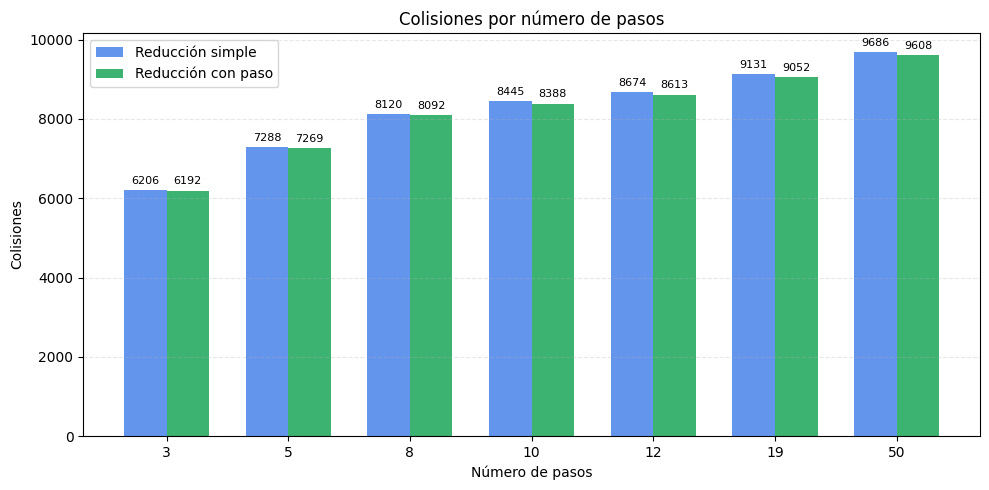

In [ ]:
x = np.arange(len(pasos))       
w = 0.35                       

fig, ax = plt.subplots(figsize=(10, 5))


b1 = ax.bar(x - w/2, col_simple, width=w,
            label='Reducción simple',  color='cornflowerblue')
b2 = ax.bar(x + w/2, col_paso,   width=w,
            label='Reducción con paso', color='mediumseagreen')


ax.set_xticks(x)
ax.set_xticklabels(pasos)
ax.set_xlabel('Número de pasos')
ax.set_ylabel('Colisiones')
ax.set_title('Colisiones por número de pasos')
ax.legend()
ax.grid(axis='y', alpha=0.3, linestyle='--')


def etiqueta_barras(barras):
    for bar in barras:
        alto = bar.get_height()
        ax.annotate(f'{alto}',
                    xy=(bar.get_x() + bar.get_width()/2, alto),
                    xytext=(0, 3),         
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

etiqueta_barras(b1)
etiqueta_barras(b2)

plt.tight_layout()
plt.show()

**Comparativa métodos**
A pesar de que la cantidad total de colisiones aumenta con el número de pasos, el método que introduce aleatoriedad muestra una clara ventaja.

Observamos en el gráfico que, aunque con más pasos hay más colisiones en general, el método con aleatoriedad genera  menos colisiones que el método simple a medida que aumentan los pasos. Esto sugiere que la aleatoriedad se **vuelve más efectiva para evitar la repetición de valores a medida que la "cadena" de operaciones se alarga**, ofreciendo un mejor rendimiento en la reducción de colisiones en iteraciones más extensas.

**Gráfico 1 (Evaluacion con 10 pasos)**

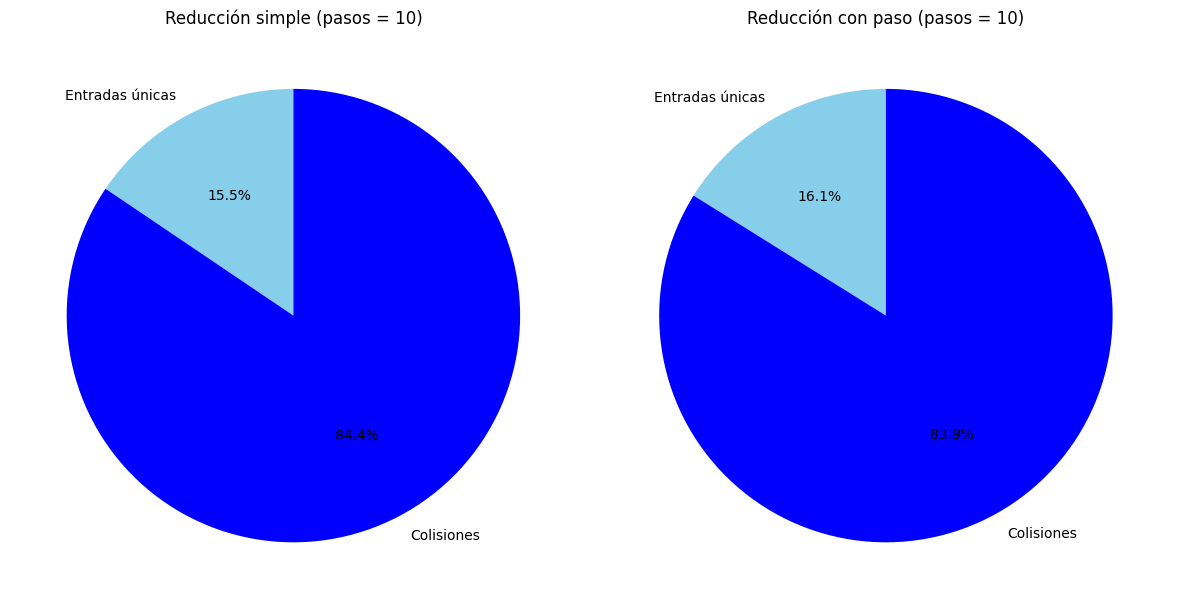

In [ ]:
i = pasos_prueba.index(10)


e_simple = entradas_simple[i]
c_simple = colisiones_simple[i]
e_paso = entradas[i]
c_paso = colisiones[i]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.pie([e_simple, c_simple], labels=['Entradas únicas', 'Colisiones'],
        autopct='%1.1f%%', startangle=90, colors=['skyblue', 'blue'])
ax1.set_title('Reducción simple (pasos = 10)')


ax2.pie([e_paso, c_paso], labels=['Entradas únicas', 'Colisiones'],
        autopct='%1.1f%%', startangle=90, colors=['skyblue', 'blue'])
ax2.set_title('Reducción con paso (pasos = 10)')

plt.tight_layout()
plt.show()

**Análisis del número de Colisiones en cada Método**


La reducción con paso introduce una variabilidad adicional (sumando el número de paso al hash), lo cual **teóricamente dispersa mejor los endpoints**.

- Sin embargo, el espacio de claves usado en esta práctica (0000–9999) es **muy limitado**: solo hay 10.000 combinaciones posibles.

- Como consecuencia:
  - A partir de cierto número de pasos, **las cadenas convergen inevitablemente** hacia los mismos endpoints.
  - El número de colisiones es practicamente similar

Si en lugar de 4 dígitos usáramos un espacio mayor:

- El espacio total se ampliaría y en este caso la variabilidad introducida por el número de paso tendría **más impacto real** en la dispersión de los endpoints.

### Éxitos en función Número de Pasos

## 6.Conclusiones y Mejoras

## 7.Uso Real

Con el objetivo de ir más allá, decidí probar una herramienta real de cracking por tablas arcoíris:**RainbowCrack.**

Esta herramienta permite utilizar tablas precomputadas para descifrar hashes de contraseñas. Para ello:
- Instalé RainbowCrack 1.8.
- Generé un archivo llamado hashes.txt, que contiene el hash MD5 de la palabra “hola”.
- Utilicé el comando rcrack.exe -f hashes.txt para intentar recuperar la contraseña desde el hash.

*La intención era verificar si el hash podía resolverse usando las tablas arcoíris reales, replicando un escenario de ataque práctico.*

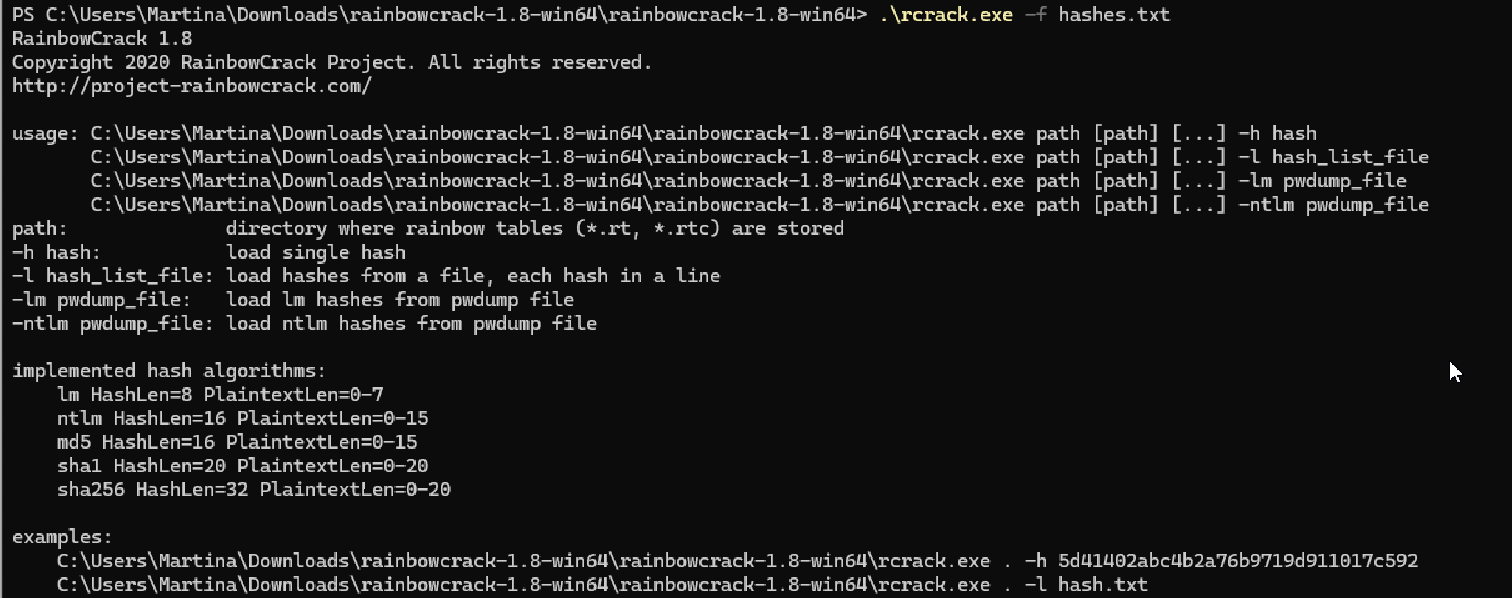